In [2]:
# Imports 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting 
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc
)

#### 1. Data Loading

In [3]:
# Load train set 
train_df = pd.read_csv('../Data/breast_cancer_trainset.csv')

print(f"Dataset shape: {train_df.shape}")
print(f"\nFirst few rows:")
train_df.head()

# Check for missing values
print("Missing values per column:")
train_df.isnull().sum()

Dataset shape: (455, 31)

First few rows:
Missing values per column:


radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
diagnosis                  0
dtype: int64


Target variable: diagnosis
diagnosis
0    285
1    170
Name: count, dtype: int64


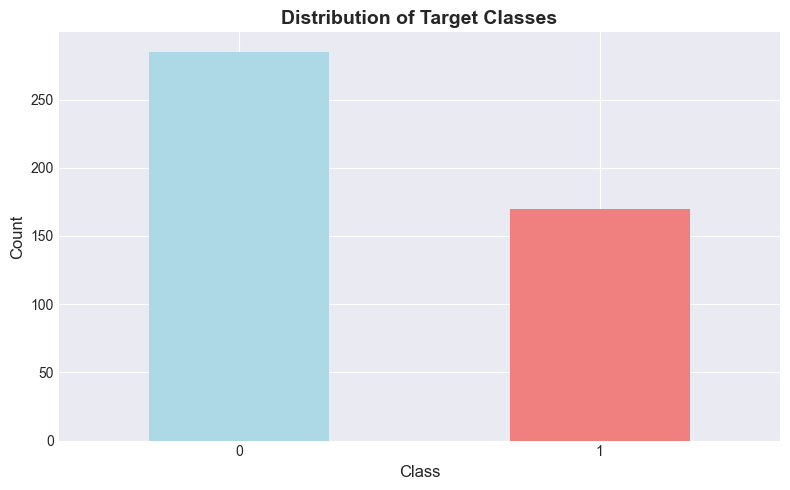

In [4]:
# Check target distribution
if 'diagnosis' in train_df.columns:
    target_col = 'diagnosis'
elif 'target' in train_df.columns:
    target_col = 'target'
else:
    target_col = train_df.columns[-1]

print(f"\nTarget variable: {target_col}")
print(train_df[target_col].value_counts())

# Visualize target distribution
plt.figure(figsize=(8, 5))
train_df[target_col].value_counts().plot(kind='bar', color=['lightblue', 'lightcoral'])
plt.title('Distribution of Target Classes', fontsize=14, fontweight='bold')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#### 2. Data Preprocessing

In [5]:
# Prepare features and target
X_train = train_df.drop(columns=['diagnosis'])
y_train = train_df['diagnosis']

# Data dimensions
print("Data Dimensions:")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")

# Target distribution
print("-"*60)
print("Target Distribution:")
print(f"Benign (0): {(y_train==0).sum()} samples ({(y_train==0).sum()/len(y_train)*100:.1f}%)")
print(f"Malignant (1): {(y_train==1).sum()} samples ({(y_train==1).sum()/len(y_train)*100:.1f}%)")
print(f"Total: {len(y_train)} samples")
print("-"*60)

Data Dimensions:
X_train: (455, 30)
y_train: (455,)
------------------------------------------------------------
Target Distribution:
Benign (0): 285 samples (62.6%)
Malignant (1): 170 samples (37.4%)
Total: 455 samples
------------------------------------------------------------


#### 3. Train Logistic Regression Model

In [7]:
# Import Pipeline and StratifiedKFold for proper workflow
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold

# Baseline Logistic Regression Pipeline
# Using Pipeline ensures StandardScaler is fit within each CV fold (no data leakage)
lr_baseline_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(random_state=42, max_iter=10000))
])

# Train on full training data
lr_baseline_pipeline.fit(X_train, y_train)

print("=" * 60)
print("BASELINE MODEL TRAINING COMPLETE")
print("=" * 60)
print("Model: Logistic Regression with default hyperparameters")
print(f"Training samples: {X_train.shape[0]}")
print(f"Features: {X_train.shape[1]}")
print("=" * 60)

BASELINE MODEL TRAINING COMPLETE
Model: Logistic Regression with default hyperparameters
Training samples: 455
Features: 30


#### 4. Hyperparameter Tuning

In [8]:
# Create pipeline for hyperparameter tuning
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(random_state=42, max_iter=10000))
])

# Parameter grid (note: use 'lr__' prefix for pipeline)
param_grid = {
    'lr__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'lr__penalty': ['l2'],
    'lr__solver': ['lbfgs', 'liblinear']
}

# Cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV with pipeline
grid_search = GridSearchCV(
    estimator=lr_pipeline,
    param_grid=param_grid,
    cv=cv_strategy,
    scoring='recall',
    n_jobs=-1,
    verbose=1
)

# Fit on RAW training data (pipeline handles scaling)
grid_search.fit(X_train, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Recall Score: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits



Best parameters: {'lr__C': 1, 'lr__penalty': 'l2', 'lr__solver': 'lbfgs'}
Best Cross-Validation Recall Score: 0.9529


#### 5. Model Evaluation

In [10]:
# Extract best model from GridSearchCV
lr_best_model = grid_search.best_estimator_

# Display best hyperparameters
print("=" * 70)
print("BEST MODEL FROM GRIDSEARCHCV")
print("=" * 70)
print("\nBest Hyperparameters:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest Cross-Validation Recall Score: {grid_search.best_score_:.4f}")
print("\n" + "=" * 70)

# Display CV results summary
cv_results_df = pd.DataFrame(grid_search.cv_results_)
top_5_models = cv_results_df.nlargest(5, 'mean_test_score')[['params', 'mean_test_score', 'std_test_score']]

print("\nTop 5 Hyperparameter Combinations (by Recall):")
print("-" * 70)
for idx, row in top_5_models.iterrows():
    print(f"\nRank {top_5_models.index.get_loc(idx) + 1}:")
    print(f"  Recall: {row['mean_test_score']:.4f} (±{row['std_test_score']:.4f})")
    print(f"  Params: {row['params']}")

BEST MODEL FROM GRIDSEARCHCV

Best Hyperparameters:
  lr__C: 1
  lr__penalty: l2
  lr__solver: lbfgs

Best Cross-Validation Recall Score: 0.9529


Top 5 Hyperparameter Combinations (by Recall):
----------------------------------------------------------------------

Rank 1:
  Recall: 0.9529 (±0.0300)
  Params: {'lr__C': 1, 'lr__penalty': 'l2', 'lr__solver': 'lbfgs'}

Rank 2:
  Recall: 0.9529 (±0.0300)
  Params: {'lr__C': 1, 'lr__penalty': 'l2', 'lr__solver': 'liblinear'}

Rank 3:
  Recall: 0.9471 (±0.0118)
  Params: {'lr__C': 0.01, 'lr__penalty': 'l2', 'lr__solver': 'liblinear'}

Rank 4:
  Recall: 0.9471 (±0.0288)
  Params: {'lr__C': 100, 'lr__penalty': 'l2', 'lr__solver': 'liblinear'}

Rank 5:
  Recall: 0.9412 (±0.0000)
  Params: {'lr__C': 0.1, 'lr__penalty': 'l2', 'lr__solver': 'liblinear'}


#### 6. Summary and Model Selection

After experimentation with Logistic Regression for breast cancer classification, we implemented a linear classifier with  hyperparameter optimization. Using GridSearchCV with 5-fold StratifiedKFold cross-validation on our training dataset of 455 samples, we tested 12 hyperparameter combinations across regularization strength (C) and solver type. The grid search optimized for recall to minimize false negatives (missed cancers). The best model achieved a cross-validation recall score of 0.9529, with optimal hyperparameters: C=1, penalty=L2, solver=lbfgs. The Pipeline ensures StandardScaler is fit within each CV fold, preventing data leakage. This model is ready for final test set evaluation after comparing with the other models.